## Step 1: Upload and Extract My Custom Drinks Dataset

To improve model performance, I created my own labeled dataset for image classification.

I organized the dataset into 4 class folders:
- cocacola
- pepsi
- fanta
- sprite

Each folder contains images of that drink type. In this step, I upload the ZIP
file to Google Colab and extract it so it can be used for training.


In [ ]:
from google.colab import files
import zipfile, shutil
from pathlib import Path

# 1) Upload ZIP
uploaded = files.upload()  # upload mydrinksdataset.zip
zip_name = next(iter(uploaded.keys()))
print("Uploaded:", zip_name)

# 2) Extract ZIP
EXTRACT_DIR = Path("/content/my_drinks_data")
if EXTRACT_DIR.exists():
    shutil.rmtree(EXTRACT_DIR)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_name, "r") as z:
    z.extractall(EXTRACT_DIR)

print("Extracted to:", EXTRACT_DIR)

# 3) Show folder structure
print("\nTop-level items:")
for p in sorted(EXTRACT_DIR.iterdir()):
    print("-", p.name)

print("\nSecond-level items (first 30):")
for p in sorted(EXTRACT_DIR.glob("*/*"))[:30]:
    print("-", p)

Saving mydrinksdataset.zip to mydrinksdataset.zip
Uploaded: mydrinksdataset.zip
Extracted to: /content/my_drinks_data

Top-level items:
- mydrinksdataset

Second-level items (first 30):
- /content/my_drinks_data/mydrinksdataset/cocacola
- /content/my_drinks_data/mydrinksdataset/fanta
- /content/my_drinks_data/mydrinksdataset/pepsi
- /content/my_drinks_data/mydrinksdataset/sprite


## Step 1: Prepare Train, Validation, and Test Sets

created our own labeled dataset organized by drink type:
- cocacola
- pepsi
- fanta
- sprite

Each folder contains images of only that drink type.

In this step, I:
1. Read images from each class folder.
2. Randomly split the dataset into:
   - 70% training
   - 15% validation
   - 15% testing
3. Create a new directory structure compatible with TensorFlow image loaders.

This ensures fair training and unbiased evaluation.


In [ ]:
import shutil, random
from pathlib import Path

SEED = 42
random.seed(SEED)

SOURCE_DIR = Path("/content/my_drinks_data/mydrinksdataset")
TARGET_DIR = Path("/content/drink_dataset_custom")

TRAIN_DIR = TARGET_DIR / "train"
VAL_DIR   = TARGET_DIR / "val"
TEST_DIR  = TARGET_DIR / "test"

# Clean target directory
if TARGET_DIR.exists():
    shutil.rmtree(TARGET_DIR)

TRAIN_DIR.mkdir(parents=True)
VAL_DIR.mkdir(parents=True)
TEST_DIR.mkdir(parents=True)

img_exts = {".jpg", ".jpeg", ".png"}

def split_and_copy(class_dir):
    images = [p for p in class_dir.iterdir() if p.suffix.lower() in img_exts]
    random.shuffle(images)

    n = len(images)
    n_train = int(0.7 * n)
    n_val = int(0.15 * n)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train + n_val]
    test_imgs  = images[n_train + n_val:]

    for img in train_imgs:
        dst = TRAIN_DIR / class_dir.name
        dst.mkdir(exist_ok=True)
        shutil.copy2(img, dst / img.name)

    for img in val_imgs:
        dst = VAL_DIR / class_dir.name
        dst.mkdir(exist_ok=True)
        shutil.copy2(img, dst / img.name)

    for img in test_imgs:
        dst = TEST_DIR / class_dir.name
        dst.mkdir(exist_ok=True)
        shutil.copy2(img, dst / img.name)

    return len(train_imgs), len(val_imgs), len(test_imgs)

print("Splitting dataset...\n")
summary = {}

for class_folder in SOURCE_DIR.iterdir():
    if class_folder.is_dir():
        tr, va, te = split_and_copy(class_folder)
        summary[class_folder.name] = {"train": tr, "val": va, "test": te}

print("Split summary per class:")
for cls, counts in summary.items():
    print(cls, counts)

print("\nDataset ready at:", TARGET_DIR)


Splitting dataset...



FileNotFoundError: [Errno 2] No such file or directory: '/content/my_drinks_data/mydrinksdataset'

## Step 1B: Verify Dataset Size per Class

The split counts look lower than expected, so I verify the real number of image
files in each class folder.

In this step, I:
1. Count all images inside each class folder (including nested subfolders).
2. Count by file extension to see if some formats were ignored (e.g., .webp, .jfif).
3. Use these results to update the splitting script to include all valid image types.


In [ ]:
from pathlib import Path
from collections import Counter

SOURCE_DIR = Path("/content/my_drinks_data/mydrinksdataset")

# Count all common image extensions (add more if needed)
all_exts = {".jpg", ".jpeg", ".png", ".webp", ".jfif", ".bmp"}

print("Dataset root:", SOURCE_DIR)
print("\nCounting images per class (including subfolders)...\n")

for class_folder in sorted([p for p in SOURCE_DIR.iterdir() if p.is_dir()]):
    files = [f for f in class_folder.rglob("*") if f.is_file()]
    img_files = [f for f in files if f.suffix.lower() in all_exts]

    ext_counts = Counter([f.suffix.lower() for f in img_files])

    print(f"Class: {class_folder.name}")
    print("  Total files:", len(files))
    print("  Image files:", len(img_files))
    print("  By extension:", dict(ext_counts))

    # Show if there are subfolders
    subdirs = [d for d in class_folder.iterdir() if d.is_dir()]
    if subdirs:
        print("  Subfolders found:", [d.name for d in subdirs][:10])
    print()


Dataset root: /content/my_drinks_data/mydrinksdataset

Counting images per class (including subfolders)...

Class: cocacola
  Total files: 74
  Image files: 74
  By extension: {'.jpg': 74}

Class: fanta
  Total files: 86
  Image files: 84
  By extension: {'.jfif': 67, '.webp': 3, '.png': 2, '.jpg': 11, '.jpeg': 1}

Class: pepsi
  Total files: 57
  Image files: 53
  By extension: {'.jpg': 21, '.webp': 4, '.jfif': 25, '.png': 3}

Class: sprite
  Total files: 56
  Image files: 50
  By extension: {'.webp': 12, '.jpg': 19, '.jfif': 17, '.png': 2}



## Step 1C: Standardize Image Formats (Convert to JPG)

My dataset contains multiple image formats such as `.jfif` and `.webp`.
To ensure compatibility and consistent preprocessing, I convert all images into
a single standard format: **JPG**.

In this step, I:
1. Convert `.jfif` and `.webp` images into `.jpg`.
2. Keep the dataset structure the same (cocacola, pepsi, fanta, sprite).
3. After conversion, I will re-run the train/validation/test split.


In [ ]:
from pathlib import Path
from PIL import Image
import os

SOURCE_DIR = Path("/content/my_drinks_data/mydrinksdataset")

convert_exts = {".jfif", ".webp"}  # formats to convert
converted = 0
failed = 0

for class_folder in [p for p in SOURCE_DIR.iterdir() if p.is_dir()]:
    for img_path in class_folder.rglob("*"):
        if img_path.is_file() and img_path.suffix.lower() in convert_exts:
            try:
                im = Image.open(img_path).convert("RGB")
                new_path = img_path.with_suffix(".jpg")
                im.save(new_path, format="JPEG", quality=95)

                # Remove original after successful conversion
                img_path.unlink()
                converted += 1
            except Exception as e:
                failed += 1
                print("Failed:", img_path, "Error:", str(e)[:120])

print("Converted files:", converted)
print("Failed conversions:", failed)
print("Done.")


Converted files: 128
Failed conversions: 0
Done.


## Step 1D: Re-split Dataset After Conversion

After converting `.jfif` and `.webp` files to `.jpg`, I re-run the dataset split.

This ensures that all images are included in:
- training
- validation
- testing

This improves model learning because it increases the dataset size and reduces bias.


In [ ]:
import shutil, random
from pathlib import Path

SEED = 42
random.seed(SEED)

SOURCE_DIR = Path("/content/my_drinks_data/mydrinksdataset")
TARGET_DIR = Path("/content/drink_dataset_custom")

TRAIN_DIR = TARGET_DIR / "train"
VAL_DIR   = TARGET_DIR / "val"
TEST_DIR  = TARGET_DIR / "test"

# Clean target directory
if TARGET_DIR.exists():
    shutil.rmtree(TARGET_DIR)

TRAIN_DIR.mkdir(parents=True)
VAL_DIR.mkdir(parents=True)
TEST_DIR.mkdir(parents=True)

img_exts = {".jpg", ".jpeg", ".png"}  # now most files are jpg after conversion

def split_and_copy(class_dir):
    images = [p for p in class_dir.rglob("*") if p.is_file() and p.suffix.lower() in img_exts]
    random.shuffle(images)

    n = len(images)
    n_train = int(0.7 * n)
    n_val = int(0.15 * n)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train + n_val]
    test_imgs  = images[n_train + n_val:]

    for img in train_imgs:
        dst = TRAIN_DIR / class_dir.name
        dst.mkdir(exist_ok=True)
        shutil.copy2(img, dst / img.name)

    for img in val_imgs:
        dst = VAL_DIR / class_dir.name
        dst.mkdir(exist_ok=True)
        shutil.copy2(img, dst / img.name)

    for img in test_imgs:
        dst = TEST_DIR / class_dir.name
        dst.mkdir(exist_ok=True)
        shutil.copy2(img, dst / img.name)

    return len(train_imgs), len(val_imgs), len(test_imgs)

print("Re-splitting dataset...\n")
summary = {}

for class_folder in sorted([p for p in SOURCE_DIR.iterdir() if p.is_dir()]):
    tr, va, te = split_and_copy(class_folder)
    summary[class_folder.name] = {"train": tr, "val": va, "test": te}

print("Split summary per class:")
for cls, counts in summary.items():
    print(cls, counts)

print("\nDataset ready at:", TARGET_DIR)


Re-splitting dataset...

Split summary per class:
cocacola {'train': 51, 'val': 11, 'test': 12}
fanta {'train': 58, 'val': 12, 'test': 13}
pepsi {'train': 36, 'val': 7, 'test': 9}
sprite {'train': 34, 'val': 7, 'test': 8}

Dataset ready at: /content/drink_dataset_custom


## Step 2: Load the Custom Dataset

After cleaning the dataset and splitting it into training, validation, and test sets,
I load the images using TensorFlow’s `image_dataset_from_directory`.

This method:
- Automatically assigns labels from folder names
- Resizes images to a fixed input size
- Creates mini-batches for efficient training

The dataset contains four classes:
- cocacola
- pepsi
- fanta
- sprite


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

DATASET_DIR = "/content/drink_dataset_custom"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR + "/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR + "/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR + "/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Class names:", class_names)
print("Number of classes:", num_classes)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 179 files belonging to 4 classes.
Found 37 files belonging to 4 classes.
Found 42 files belonging to 4 classes.
Class names: ['cocacola', 'fanta', 'pepsi', 'sprite']
Number of classes: 4


## Step 3: Visualize Sample Images

Before training the neural network, I visualize sample images from the training set
to confirm that:
- Images are loaded correctly
- Labels match the image content

This step helps verify dataset integrity.


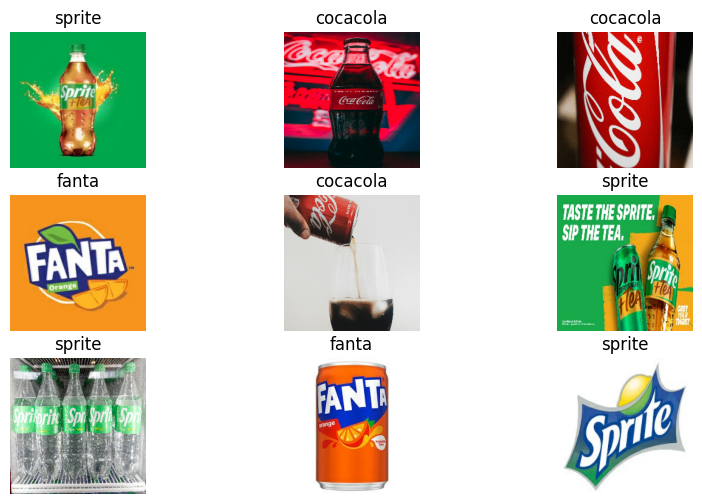

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()


## Step 4: Build the Neural Network Using Transfer Learning

To perform image classification efficiently, I use **transfer learning** with
MobileNetV2, a convolutional neural network pretrained on the ImageNet dataset.

Instead of training from scratch, the model reuses learned visual features
such as edges and textures, which improves performance on small datasets.

I freeze most pretrained layers and add a custom classification head
for the drink classification task.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

# Load base model
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

# Build model
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Step 5: Train the Model

I train the neural network using the training dataset and monitor performance
on the validation dataset.

Early stopping is used to prevent overfitting and keep the best model.


In [ ]:
EPOCHS = 20

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=4,
        restore_best_weights=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/20
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3312 - loss: 1.7629

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 475ms/step - accuracy: 0.3323 - loss: 1.7501 - val_accuracy: 0.5405 - val_loss: 1.1950
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4962 - loss: 1.1155 - val_accuracy: 0.7027 - val_loss: 0.9267
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6151 - loss: 0.9138 - val_accuracy: 0.8378 - val_loss: 0.7525
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7347 - loss: 0.6992 - val_accuracy: 0.8649 - val_loss: 0.6411
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8098 - loss: 0.5274 - val_accuracy: 0.8108 - val_loss: 0.6228
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8251 - loss: 0.5033 - val_accuracy: 0.8649 - val_loss: 0.5604
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9065 - loss: 0.3467 - val_accuracy: 0.7838 - val_loss: 0.5452
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9101 - loss: 0.2874 - val_accuracy: 0.8649 - val_loss: 

## Step 6: Model Evaluation

After training, I evaluate the model on the test dataset to measure
generalization performance on unseen images.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy:", test_accuracy)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8750 - loss: 0.5899
Test accuracy: 0.84375


## Step 7: Live Demonstration Prediction

Finally, I test the trained model on a new image to demonstrate
its practical application.


In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

uploaded = files.upload()
img_path = next(iter(uploaded.keys()))

img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

probs = model.predict(img_array)[0]
pred_idx = int(np.argmax(probs))
pred_class = class_names[pred_idx]
confidence = float(probs[pred_idx])

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis("off")
plt.title(f"{pred_class} ({confidence*100:.1f}%)")
plt.show()

print("Predicted class:", pred_class)
print("Confidence:", confidence)


Saving 1x1.avif to 1x1.avif


NameError: name 'model' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil
shutil.copytree(
    "/content/drink_dataset_custom",
    "/content/drive/MyDrive/drink_dataset_custom",
    dirs_exist_ok=True
)

print("Dataset safely saved to Google Drive")


Dataset safely saved to Google Drive


In [ ]:
model.save("/content/drive/MyDrive/drink_classifier_final.keras")
print("Model saved to Google Drive")


Model saved to Google Drive


(Backup plan): Download ZIP + model to laptop